In [1]:
1+1

2

In [2]:
import numpy as np
from numba import njit
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import pickle
from datetime import datetime
import strax
import straxen
import cutax
from tqdm.notebook import tqdm, trange
strax.utils.tqdm = tqdm
from multihist import Hist1d, Histdd

import copy
from matplotlib import cm


In [3]:
st = cutax.xenonnt_online(
    output_folder='/dali/lgrandi/scli/strax_data',
    # include_online_monitor=True,
    include_rucio_local=True,
    # download_heavy=True
)

In [4]:
runs_all = st.select_runs(
    # include_tags='sr0_preliminary', 
    exclude_tags=(
        'ramp_up',
        'messy',
        'bad',
        'abandon',
        'hot_spot'
    ),
    run_mode=[
        'ybe_linked'
    ]
)

# exclude_runs = ['039414', '039420', '039426']

# runs_all = runs_all.query('peak_basics_available == True and not name in @exclude_runs')
runs_all = runs_all.query('peak_basics_available == True')

Checking data availability:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
run_name='047701'

In [6]:
peaks_ = st.get_df(run_name, ('peak_basics', 'peak_positions')
                     # selection_str = ('cs1 < 50','cs1 > 0','cs2 >= 10', 'cs2 <= 4000')
                     )

Loading plugins: |          | 0.00 % [00:00<?]

In [7]:
peaks_.keys()

Index(['time', 'endtime', 'center_time', 'area', 'n_hits', 'n_channels',
       'max_pmt', 'max_pmt_area', 'n_saturated_channels', 'range_50p_area',
       'range_90p_area', 'area_fraction_top', 'length', 'dt', 'rise_time',
       'tight_coincidence', 'tight_coincidence_channel', 'type', 'x_cnn',
       'y_cnn', 'x_mlp', 'y_mlp', 'x_gcn', 'y_gcn', 'x', 'y'],
      dtype='object')

In [14]:
radius = 66.4
height = 148.6

In [30]:
I_belt_tan=91.6/42.6
a=radius/np.sqrt(I_belt_tan**2+1)

In [32]:
s2=peaks_[peaks_.type==2]
s2['r2']=s2.x**2+s2.y**2
s2['dr2']=(s2.x-a*I_belt_tan)**2+(s2.y-a)**2

/tmp/jobs/22969075/ipykernel_136/570326575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2['r2']=s2.x**2+s2.y**2
/tmp/jobs/22969075/ipykernel_136/570326575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2['dr2']=(s2.x-a*I_belt_tan)**2+(s2.y-a)**2


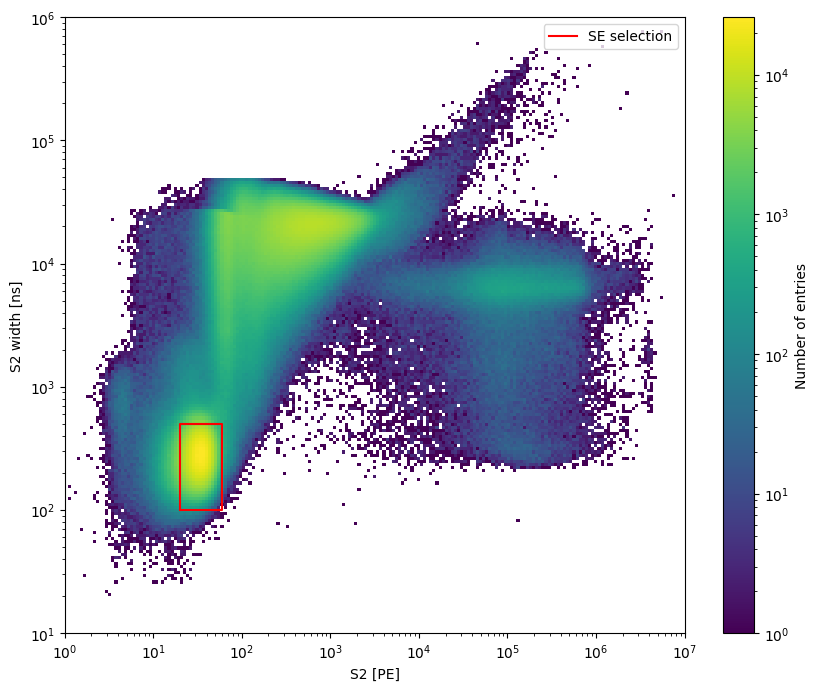

In [33]:
plt.figure(figsize=(10, 8))

bin_config = dict(bins=(np.logspace(0, 7, 200), np.logspace(1, 6, 200)))
h = Histdd(s2["area"], s2["range_50p_area"], **bin_config)
h.plot(log_scale=True)

rate_box_s2 = [20, 60]
rate_box_width = [1e2, 5e2]

plt.plot(
    [rate_box_s2[0], rate_box_s2[0], rate_box_s2[1], rate_box_s2[1], rate_box_s2[0]],
    [rate_box_width[0], rate_box_width[1], rate_box_width[1], rate_box_width[0], rate_box_width[0]],
    color='r', label='SE selection'
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel('S2 [PE]')
plt.ylabel('S2 width [ns]')
plt.legend()
plt.show()

In [34]:
sel=s2.area>rate_box_s2[0]
sel&=s2.area<rate_box_s2[1]
sel&=s2.range_50p_area>rate_box_width[0]
sel&=s2.range_50p_area<rate_box_width[1]

In [35]:
se=s2[sel]

In [36]:
ac=[]
for i in range(5):
    sel=(s2.area>100*i)
    sel&=(s2.area<100*(i+1))
    tmp=s2[sel]
    ac.append(tmp)

In [37]:
se=[]
for i in range(5):
    sel=(s2.area>32*i+16)
    sel&=(s2.area<32*(i+1)+16)
    tmp=s2[sel]
    se.append(tmp)

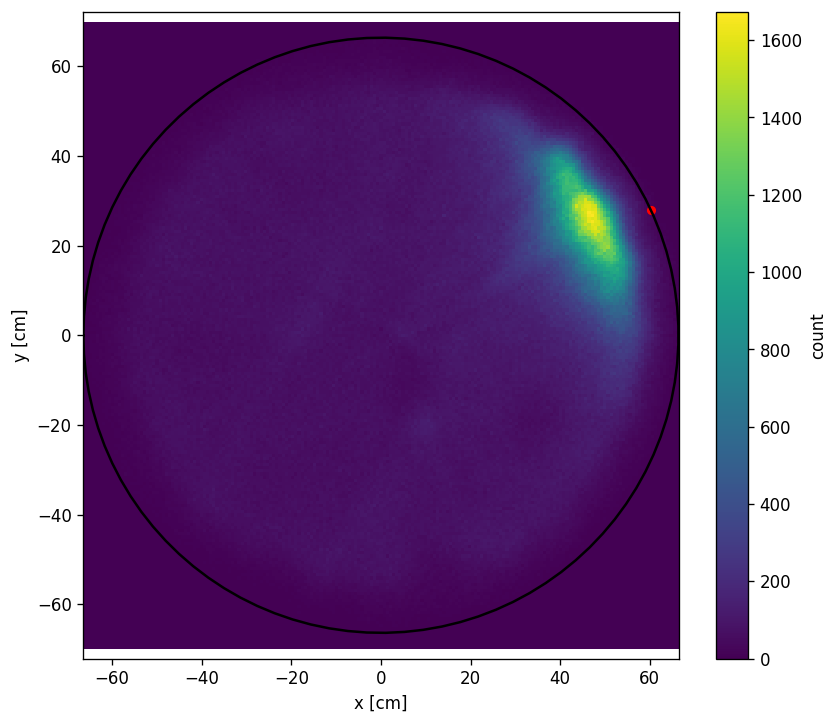

In [38]:
nbins=200
size=70
hist_x_y, edges_x_y = np.histogramdd([se[0]['x'].values, se[0]['y'].values], bins=[np.linspace(-size, size, nbins), np.linspace(-size, size, nbins)])
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)


ax.axis('equal')
h = ax.pcolormesh(edges_x_y[0], edges_x_y[1], hist_x_y.T)
theta = np.linspace(-np.pi, np.pi, 100)
x = np.cos(theta)*radius
y = np.sin(theta)*radius
ax.set(xlabel='x [cm]', ylabel='y [cm]',xlim=[-radius, radius],ylim=[-radius, radius])
ax.plot(x,y, color='black')
ax.scatter(x=[a*I_belt_tan],y=[a],s=20,c='r')
plt.colorbar(h, label='count')
plt.show()

In [40]:
bin_size=size*2/nbins
time=runs_all[runs_all.name==run_name]['livetime']

In [41]:
seconds = time.values[0]/ np.timedelta64(1, 's')
seconds

3603.171

In [42]:
hist_rate=hist_x_y/(bin_size**2*seconds)

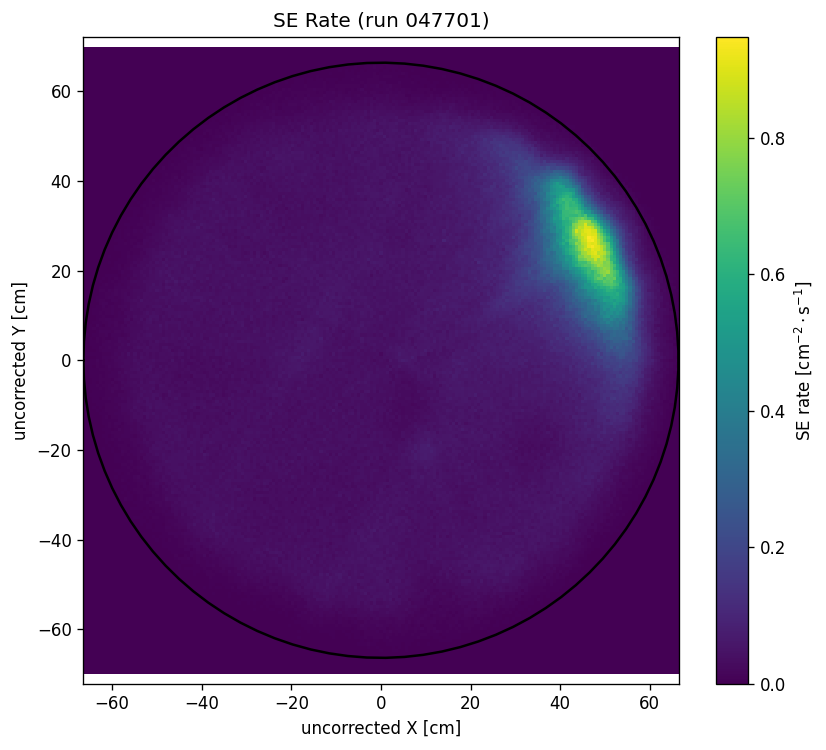

In [43]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.axis('equal')
h = ax.pcolormesh(edges_x_y[0], edges_x_y[1], hist_rate.T)
theta = np.linspace(-np.pi, np.pi, 100)
x = np.cos(theta)*radius
y = np.sin(theta)*radius
ax.set(xlabel='uncorrected X [cm]', ylabel='uncorrected Y [cm]',xlim=[-radius, radius],ylim=[-radius, radius])
ax.plot(x,y, color='black')
plt.colorbar(h, label='SE rate [cm$^{-2}\cdot$s$^{-1}$]')
plt.title(f'SE Rate (run {run_name})')
plt.show()

In [54]:
filename ='/dali/lgrandi/pkavrigin/2022-08-07_YBeNeutron/ybe_neutron_nr_event_info.csv'
df_nr = pd.read_csv(filename)
df_nr['s2_r2']=df_nr['s2_x']**2+df_nr['s2_y']**2
df_nr['dr2']=(df_nr['s2_x']-a*I_belt_tan)**2+(df_nr['s2_y']-a)**2

In [55]:
# sel=df_nr['s2_area']>20
# sel&=df_nr['s2_area']<60
# df_nr=df_nr[sel]

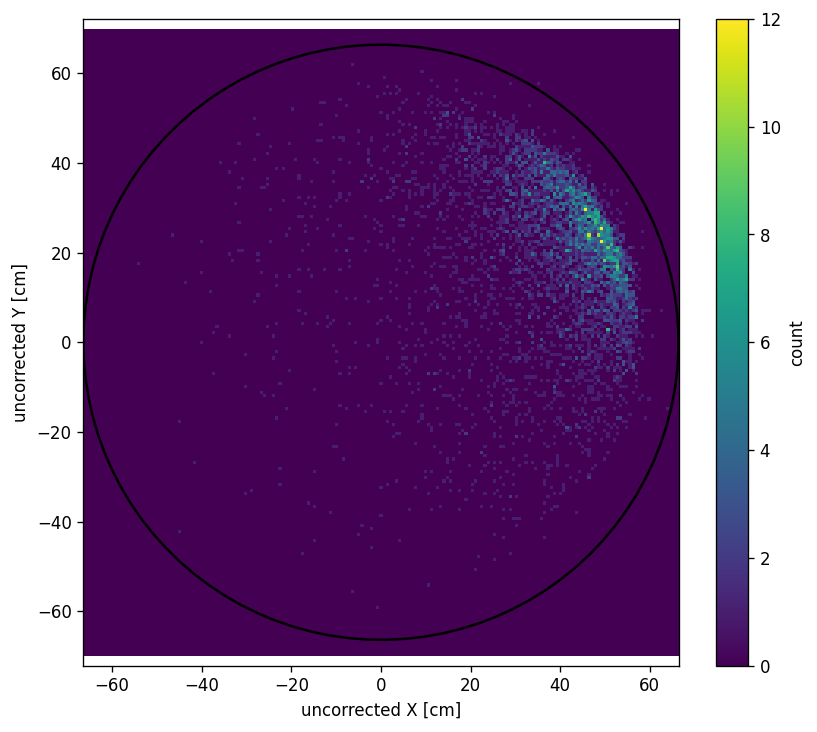

In [56]:
hist_x_y_1, edges_x_y_1 = np.histogramdd([df_nr['s2_x'].values, df_nr['s2_y'].values], bins=[np.linspace(-size, size, nbins), np.linspace(-size, size, nbins)])
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.axis('equal')
h = ax.pcolormesh(edges_x_y[0], edges_x_y[1], hist_x_y_1.T)
theta = np.linspace(-np.pi, np.pi, 100)
x = np.cos(theta)*radius
y = np.sin(theta)*radius
ax.set(xlabel='uncorrected X [cm]', ylabel='uncorrected Y [cm]',xlim=[-radius, radius],ylim=[-radius, radius])
ax.plot(x,y, color='black')
plt.colorbar(h, label='count')
plt.show()

In [57]:
nr_seconds=81*3600

In [58]:
hist_rate_nr=hist_x_y_1/(bin_size**2*nr_seconds)

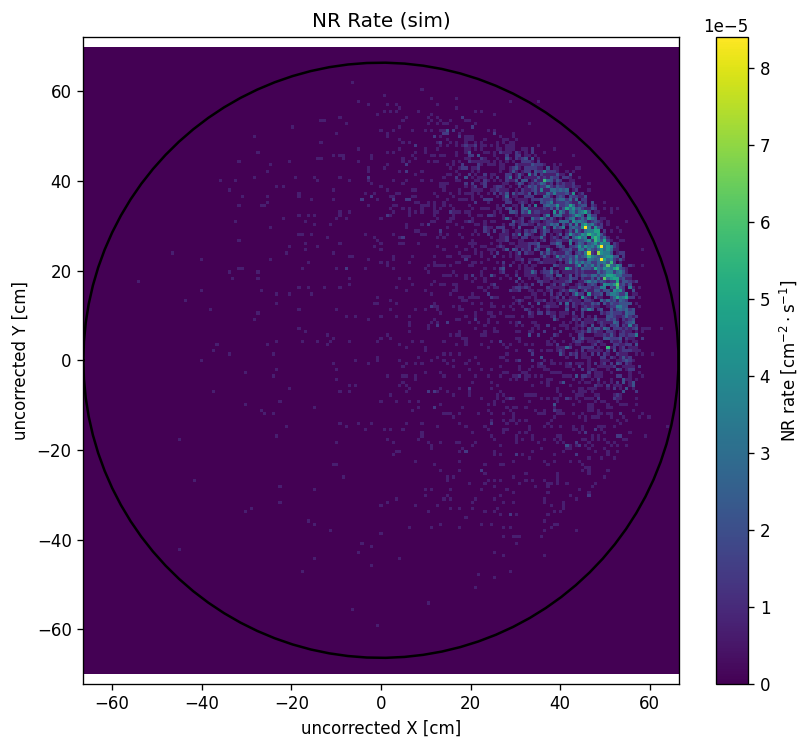

In [59]:
fig = plt.figure(figsize=(8, 7), dpi=120)
ax = fig.add_subplot(111)
ax.axis('equal')
h = ax.pcolormesh(edges_x_y[0], edges_x_y[1], hist_rate_nr.T)
theta = np.linspace(-np.pi, np.pi, 100)
x = np.cos(theta)*radius
y = np.sin(theta)*radius
ax.set(xlabel='uncorrected X [cm]', ylabel='uncorrected Y [cm]',xlim=[-radius, radius],ylim=[-radius, radius])
ax.plot(x,y, color='black')
plt.colorbar(h, label='NR rate [cm$^{-2}\cdot$s$^{-1}$]')
plt.title('NR Rate (sim)')
plt.show()

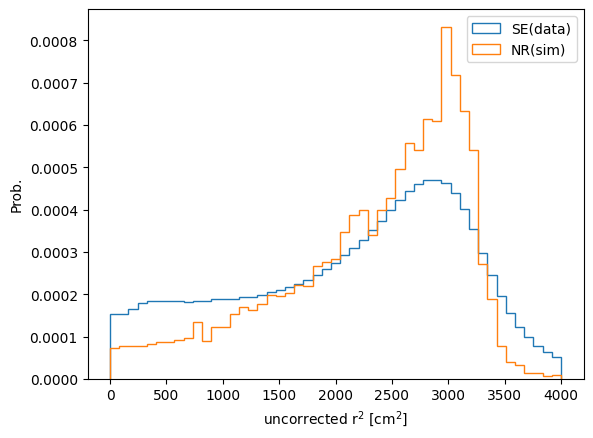

In [60]:
bins=np.linspace(0,4000,50)
plt.hist(se[0]['r2'],bins=bins,histtype='step',label='SE(data)',density=True)
plt.hist(df_nr['s2_r2'],bins=bins,histtype='step',label='NR(sim)',density=True)
plt.xlabel('uncorrected r$^2$ [cm$^2$]')
plt.ylabel('Prob.')
plt.legend()
plt.show()

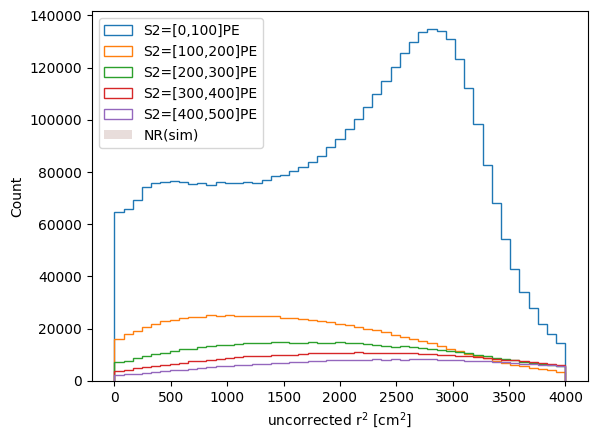

In [61]:
bins=np.linspace(0,4000,50)
for i in range(5):
    plt.hist(ac[i]['r2'],bins=bins,histtype='step',label=f'S2=[{100*i},{100*i+100}]PE',density=False)

plt.hist(df_nr['s2_r2'],bins=bins,histtype='bar',label='NR(sim)',density=True,alpha=0.2)
plt.xlabel('uncorrected r$^2$ [cm$^2$]')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

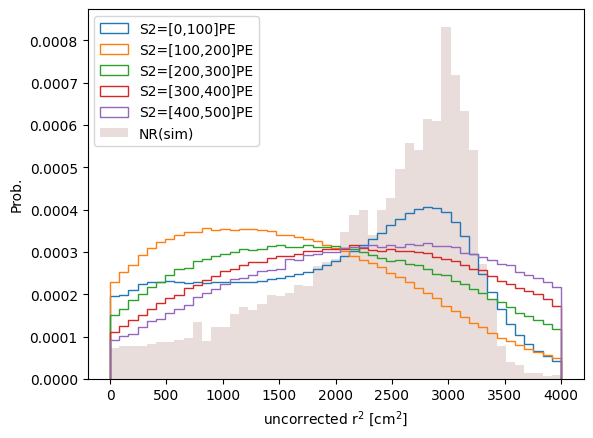

In [62]:
bins=np.linspace(0,4000,50)
for i in range(5):
    plt.hist(ac[i]['r2'],bins=bins,histtype='step',label=f'S2=[{100*i},{100*i+100}]PE',density=True)

plt.hist(df_nr['s2_r2'],bins=bins,histtype='bar',label='NR(sim)',density=True,alpha=0.2)
plt.xlabel('uncorrected r$^2$ [cm$^2$]')
plt.ylabel('Prob.')
plt.legend(loc='upper left')
plt.show()

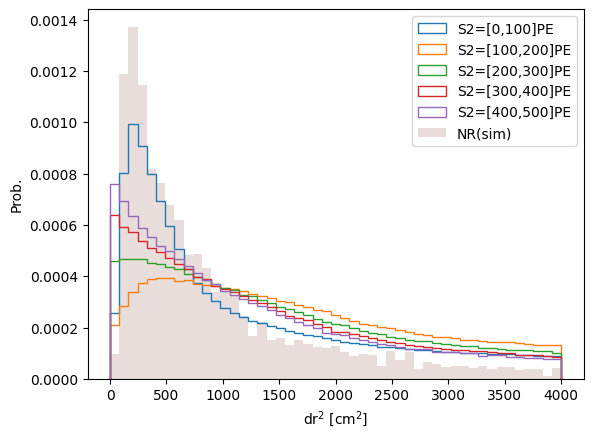

In [66]:
bins=np.linspace(0,4000,50)
for i in range(5):
    plt.hist(ac[i]['dr2'],bins=bins,histtype='step',label=f'S2=[{100*i},{100*i+100}]PE',density=True)

plt.hist(df_nr['dr2'],bins=bins,histtype='bar',label='NR(sim)',density=True,alpha=0.2)
plt.xlabel('dr$^2$ [cm$^2$]')
plt.ylabel('Prob.')
plt.legend()
plt.show()

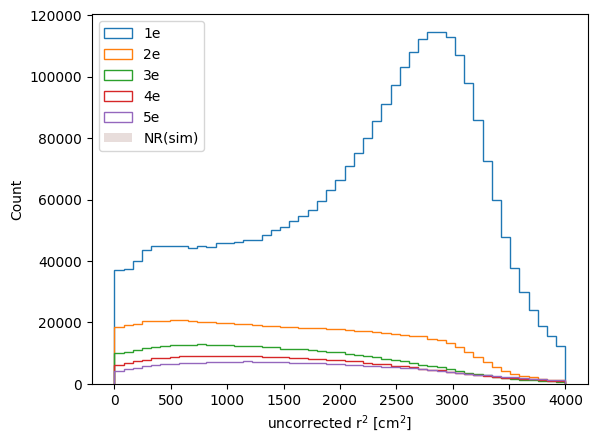

In [37]:
bins=np.linspace(0,4000,50)
for i in range(5):
    plt.hist(se[i]['r2'],bins=bins,histtype='step',label=f'{i+1}e',density=False)

plt.hist(df_nr['s2_r2'],bins=bins,histtype='bar',label='NR(sim)',density=True,alpha=0.2)
plt.xlabel('uncorrected r$^2$ [cm$^2$]')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

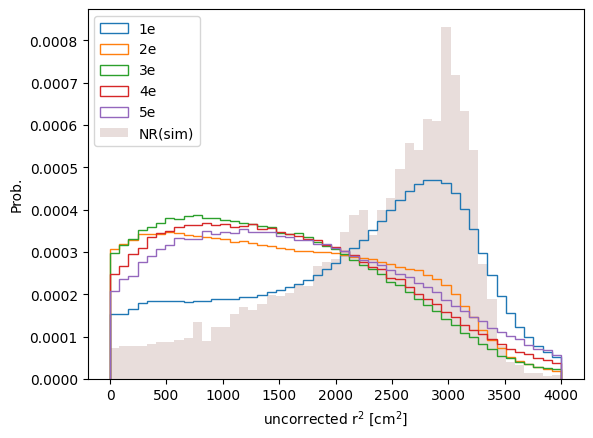

In [39]:
bins=np.linspace(0,4000,50)
for i in range(5):
    plt.hist(se[i]['r2'],bins=bins,histtype='step',label=f'{i+1}e',density=True)

plt.hist(df_nr['s2_r2'],bins=bins,histtype='bar',label='NR(sim)',density=True,alpha=0.2)
plt.xlabel('uncorrected r$^2$ [cm$^2$]')
plt.ylabel('Prob.')
plt.legend(loc='upper left')
plt.show()

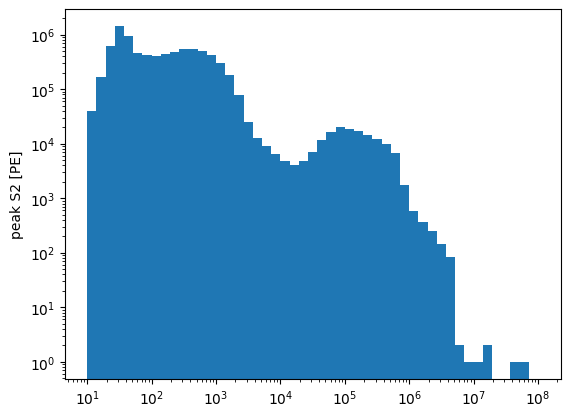

In [27]:
h1=plt.hist(s2['area'],np.logspace(1,8,50))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('count')
plt.ylabel('peak S2 [PE]')
plt.show()

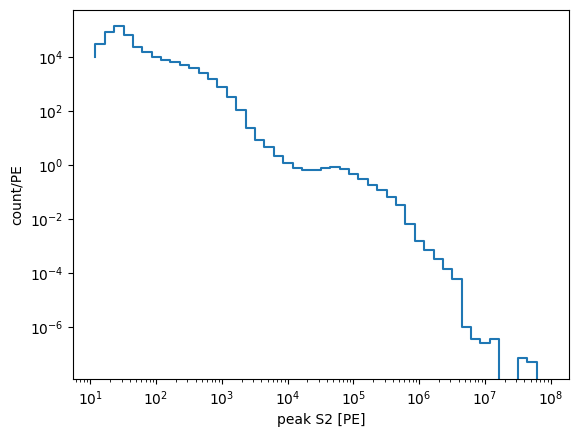

In [28]:
rate=h1[0]/(h1[1][1:]-h1[1][:-1])
bin_c=(h1[1][1:]+h1[1][:-1])/2
plt.step(bin_c,rate)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('count/PE')
plt.xlabel('peak S2 [PE]')
plt.show()

In [29]:
nr=[]
for i in range(5):
    sel=(df_nr.s2_area>100*i)
    sel&=(df_nr.s2_area<100*(i+1))
    tmp=df_nr[sel]
    nr.append(tmp)

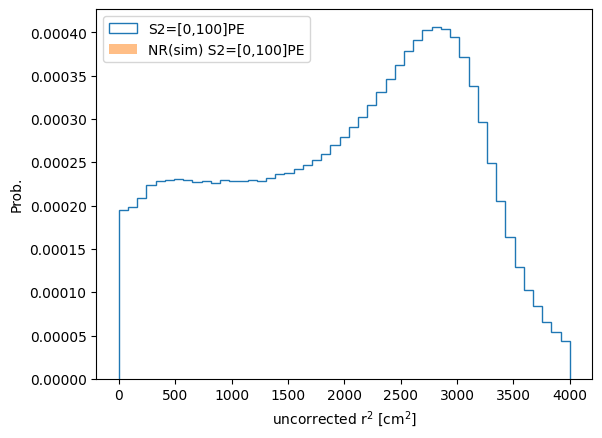

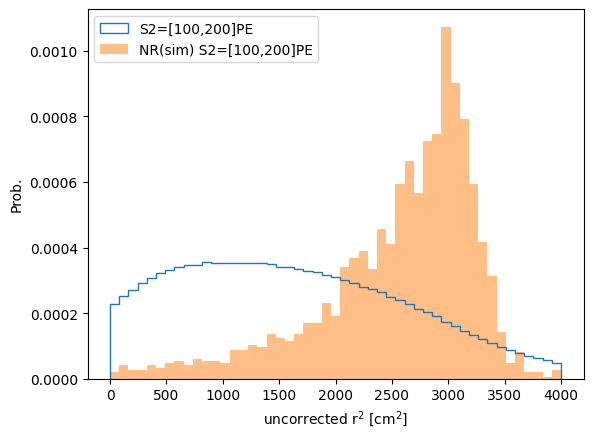

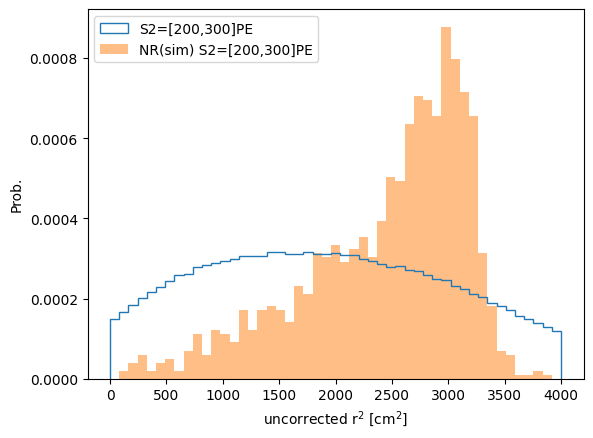

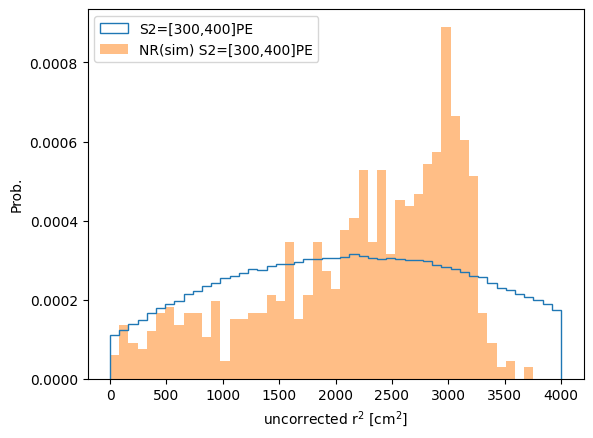

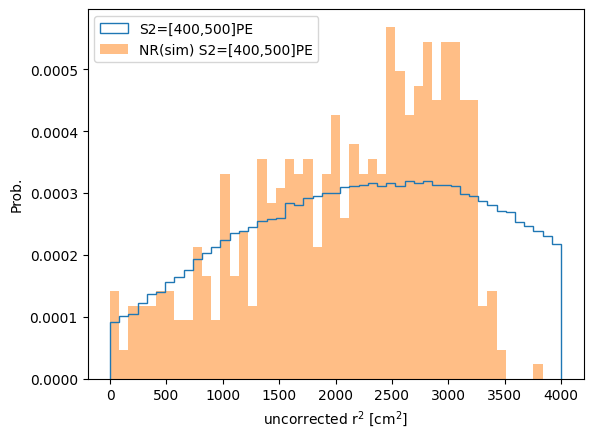

In [42]:
bins=np.linspace(0,4000,50)
for i in range(5):
    plt.figure()
    plt.hist(ac[i]['r2'],bins=bins,histtype='step',label=f'S2=[{100*i},{100*i+100}]PE',density=True)
    plt.hist(nr[i]['s2_r2'],bins=bins,histtype='bar',label=f'NR(sim) S2=[{100*i},{100*i+100}]PE',density=True,alpha=0.5)
    plt.xlabel('uncorrected r$^2$ [cm$^2$]')
    plt.ylabel('Prob.')
    plt.legend(loc='upper left')
    plt.show()

In [61]:
np.sum(runs_all['livetime'])

Timedelta('3 days 19:03:56.180000')